### Standardized Mooring Supply Chain Analysis


In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ORBIT import ProjectManager, load_config

from ORBIT.phases.design import CustomMooringSystemDesign
from ORBIT.phases.install import MooringSystemSupplyChain

In [26]:
INPUTS = os.path.join(os.getcwd(), "inputs")
RESULTS = os.path.join(os.getcwd(), "results")
if not os.path.exists(RESULTS):
    os.mkdir(RESULTS)

#### Morro Bay config

In [27]:
config_MB = load_config(os.path.join(INPUTS, "custom_MorroBay.yaml"))

weather_MB = None
print("Distance: ", config_MB["site"]["distance"])
print("Number of Turbines: ", config_MB["plant"]["num_turbines"])
print("Turbine: ", config_MB["turbine"])

config_MB["custom_filename"] = "custom_mooring_MorroBay.csv"


Distance:  100
Number of Turbines:  3
Turbine:  15MW_generic


In [28]:
try:
  ProjectManager.register_design_phase(CustomMooringSystemDesign)
  ProjectManager.register_install_phase(MooringSystemSupplyChain)

except ValueError:
  pass

baseline_MB = ProjectManager(config_MB, weather=weather_MB)
baseline_MB.run()

print(f"\nPhases: {list(baseline_MB._phases)}")
print(
      f"\nLead Time: {baseline_MB.installation_time:.0f} h ({baseline_MB.installation_time/8760:.2f} years)"
    )

   turbine_id line_id    section_id  ...  mass  thickness  cost_rate
0           1       A  chain_bottom  ...   5.5        NaN          0
1           1       B  chain_bottom  ...   5.6        NaN          0
2           1       C  chain_bottom  ...   7.1        NaN          0
3           1       D  chain_bottom  ...   7.1        NaN          0
4           1       E  chain_bottom  ...   4.0        NaN          0

[5 rows x 8 columns]
Laydown Vars: {'buffer': 3501, 'env': Environment, 'pending': [], 'max_area': 40500, '_trigger': 0.0, '_env': Environment, '_capacity': inf, 'put_queue': [], 'get_queue': [], 'items': [], 'start_assembly': <Event() object at 0x28a6e7ee0>}
Number of chains: 36
{'type': 'chain_bottom_d84', 'area': 7.5, 'length': 39.9, 'mass': 5.6, 'turb_id': 1, 'line_id': 'B', 'thickness': nan, 'cost_rate': 0}
{'transport_specs': {'max_waveheight': 3, 'max_windspeed': 25, 'transit_speed': 10}, 'vessel_specs': {'day_rate': 30000, 'overall_length': 150, 'mobilization_days': 7, '

In [29]:
df_actions_MB = pd.DataFrame(baseline_MB.actions)

pd.DataFrame(df_actions_MB).to_csv(
        os.path.join(RESULTS, "MorroBay_baseline_project.csv")
)
df_actions_MB

,cost,supply_storage,agent,action,duration,level,time,phase,cost_multiplier,transport_storage,port_storage,port_capacity
0,0.0,1.0,Chain Production 1,"1, Manufacture: chain_bottom_d83",7.0000,ACTION,7.0000,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
1,0.0,NaN,Chain Transport Vessel,Mobilize,0.0000,ACTION,7.0000,MooringSystemSupplyChain,0.0,NaN,NaN,NaN
2,0.0,0.0,Chain Transport Vessel,Loading cargo,0.0000,ACTION,7.0000,MooringSystemSupplyChain,NaN,1.0,NaN,NaN
3,0.0,1.0,Chain Production 1,"2, Manufacture: chain_bottom_d84",6.9825,ACTION,13.9825,MooringSystemSupplyChain,NaN,NaN,NaN,NaN
4,0.0,NaN,Chain Transport Vessel,Waiting for chain to load.,6.9825,ACTION,13.9825,MooringSystemSupplyChain,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
127,0.0,0.0,Chain Transport Vessel,Put cargo at Port Laydown.,0.0000,ACTION,1469.2650,MooringSystemSupplyChain,NaN,3.0,40252.5,34.0
128,0.0,0.0,Chain Transport Vessel,Put cargo at Port Laydown.,0.0000,ACTION,1469.2650,MooringSystemSupplyChain,NaN,2.0,40245.0,35.0
129,0.0,0.0,Chain Transport Vessel,Put cargo at Port Laydown.,0.0000,ACTION,1469.2650,MooringSystemSupplyChain,NaN,1.0,40237.5,36.0
130,0.0,0.0,Chain Transport Vessel,Put cargo at Port Laydown.,0.0000,ACTION,1469.2650,MooringSystemSupplyChain,NaN,0.0,40230.0,37.0


['Chain Production 1' 'Chain Transport Vessel']


KeyError: 'days_to_start'

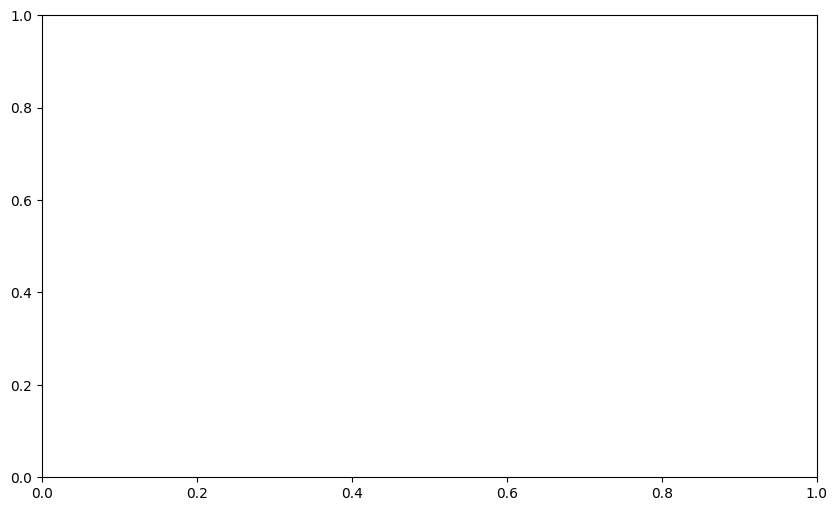

In [30]:
# Plot logic
import numpy as np
plot_based_on = 'agent'

agents = df_actions_MB['agent'].unique()
#agents = ['Substructure Assembly Line 1', '3 Tugs (Group 1)', 'AHTS + 2 Tugs']
print(agents)

#wrapped_agents_dic = [textwrap.fill(a, width=16) for a in agents]

color_sns_hex= (sns.color_palette("Set1").as_hex() +
                sns.color_palette("Set2").as_hex() +
                sns.color_palette("Set3").as_hex()
)

def color(row):

    c_dict = {agents[i]: color_sns_hex[i+1] for i in range(len(agents))}
    #print(c_dict)
    return c_dict[row['agent']]

df_plot = df_actions_MB
df_plot['color'] = df_plot.apply(color, axis=1)
# make delays red
df_plot.loc[df_plot["action"].str.contains('Delay'), "color"] = '#FF0000'

fig, ax = plt.subplots(1, figsize=(10,6))
#fig.suptitle("Aikido Floating Offshore Project: CA")

ax.barh(y=df_plot[plot_based_on],
           width=df_plot['duration'],
           left=0,
           color=df_plot.color)

#ax.set_title('Install Schedule:' + (df_plot['start_date'].min()).strftime("%m/%d/%y")
#             + ' to ' + (df_plot['end_date'].max()).strftime("%m/%d/%y")
#             )

num_x_labels = 5
#day_spacing = int(((df_plot['end_date'].max() - df_plot['start_date'].min()).days)/num_x_labels)
#xticks = np.arange(0, df_plot['days_to_end'].max()+1, day_spacing)
#ax.set_xticks(xticks)
ax.set_xlabel("Installation Duration", fontdict=dict(weight='bold'))

ax.set_yticklabels(agents)
plt.gca().invert_yaxis()
fig.subplots_adjust(left=0.32)

plt.show()

